In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
!nvidia-smi

Fri Apr 23 17:22:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   66C    P0   114W / 150W |   5392MiB /  7618MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [9]:
base_dir = './pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


[[[0.5281468  0.5281468  0.5281468 ]
  [0.5129113  0.5129113  0.5129113 ]
  [0.49701163 0.49701163 0.49701163]
  ...
  [0.2975255  0.2975255  0.2975255 ]
  [0.2739997  0.2739997  0.2739997 ]
  [0.1911321  0.1911321  0.1911321 ]]

 [[0.561557   0.561557   0.561557  ]
  [0.5483157  0.5483157  0.5483157 ]
  [0.53559595 0.53559595 0.53559595]
  ...
  [0.3041307  0.3041307  0.3041307 ]
  [0.24536791 0.24536791 0.24536791]
  [0.14536072 0.14536072 0.14536072]]

 [[0.60424525 0.60424525 0.60424525]
  [0.58424693 0.58424693 0.58424693]
  [0.5699372  0.5699372  0.5699372 ]
  ...
  [0.27799338 0.27799338 0.27799338]
  [0.1983207  0.1983207  0.1983207 ]
  [0.15755814 0.15755814 0.15755814]]

 ...

 [[0.5133547  0.5133547  0.5133547 ]
  [0.43833026 0.43833026 0.43833026]
  [0.4032209  0.4032209  0.4032209 ]
  ...
  [0.16562708 0.16562708 0.16562708]
  [0.17039697 0.17039697 0.17039697]
  [0.16905856 0.16905856 0.16905856]]

 [[0.47850496 0.47850496 0.47850496]
  [0.4034805  0.4034805  0.4034805 ]


IndexError: list index out of range

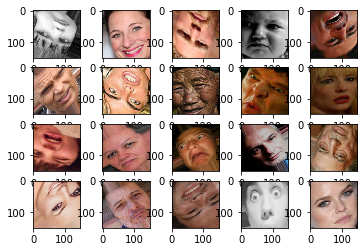

In [11]:
fig = plt.figure()
fig_arr = list()
for i in range(20):
    fig_arr.append(fig.add_subplot(4,5,i+1))

for data_batch, lable_batch in validation_generator:
    for idx, img_data in enumerate(data_batch):
        print(img_data)
        fig_arr[idx].imshow(img_data, cmap='gray')
    break

plt.tight_layout()
plt.show()

# 전이 학습

In [6]:
# pretrained network
model_base = InceptionResNetV2(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

219062272/219055592 [==============================] - 8s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_____________

activation_130 (Activation)     (None, 7, 7, 160)    0           batch_normalization_130[0][0]    
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 7, 7, 192)    208896      block17_13_ac[0][0]              
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 7, 7, 192)    215040      activation_130[0][0]             
__________________________________________________________________________________________________
batch_normalization_128 (BatchN (None, 7, 7, 192)    576         conv2d_128[0][0]                 
__________________________________________________________________________________________________
batch_normalization_131 (BatchN (None, 7, 7, 192)    576         conv2d_131[0][0]                 
__________________________________________________________________________________________________
activation

In [7]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dropout (Dropout)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 96775     
Total params: 54,433,511
Trainable params: 96,775
Non-trainable params: 54,336,736
_________________________________________________________________


# Fine Tuning

In [8]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

"\nmodel_base.trainable=True\n\n# 상위 layer 동결해제\nfor layer in model_base.layers:\n    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:\n        layer.trainable=True\n    else:\n        layer.trainable=False\n\n# learning_rate 더 작게 설정\nmodel.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',\n              metrics=['accuracy'])\n"

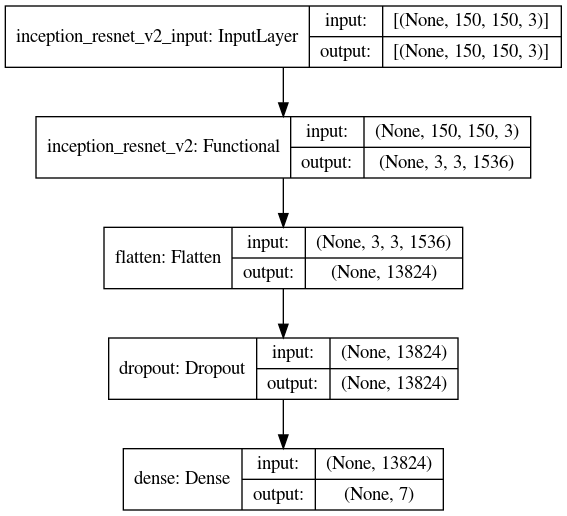

In [9]:
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/InceptionResNetV2_1/InceptionResNetV2_1-1.png')

In [10]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

Epoch 1/20
159/159 [==============================] - 138s 771ms/step - loss: 2.9001 - accuracy: 0.2454 - val_loss: 1.7634 - val_accuracy: 0.4172
Epoch 2/20
159/159 [==============================] - 114s 714ms/step - loss: 2.3396 - accuracy: 0.3328 - val_loss: 1.6706 - val_accuracy: 0.4185
Epoch 3/20
159/159 [==============================] - 117s 733ms/step - loss: 2.1508 - accuracy: 0.3653 - val_loss: 1.6062 - val_accuracy: 0.4313
Epoch 4/20
159/159 [==============================] - 114s 716ms/step - loss: 2.0224 - accuracy: 0.3882 - val_loss: 1.5866 - val_accuracy: 0.4590
Epoch 5/20
159/159 [==============================] - 116s 733ms/step - loss: 1.9350 - accuracy: 0.4033 - val_loss: 1.5476 - val_accuracy: 0.4521
Epoch 6/20
159/159 [==============================] - 114s 715ms/step - loss: 1.8027 - accuracy: 0.4351 - val_loss: 1.5228 - val_accuracy: 0.4638
Epoch 7/20
159/159 [==============================] - 117s 734ms/step - loss: 1.7455 - accuracy: 0.4422 - val_loss: 1.5269 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


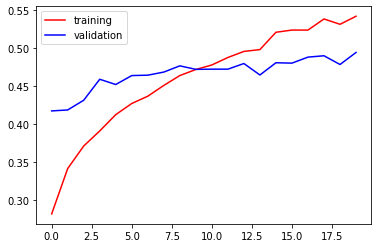

In [11]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_acc.jpg')
plt.show()

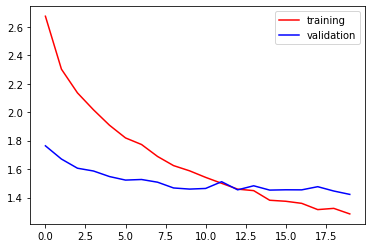

In [12]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_val.jpg')
plt.show()

In [13]:
result = model.evaluate(test_generator)
print(np.round(result, 4))

21/21 [==============================] - 7s 316ms/step - loss: 1.3320 - accuracy: 0.5145
[1.332  0.5145]


In [14]:
model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-1.h5')